In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MySQLdb, pickle
import pandas as pd
from sqlalchemy import create_engine
from collections import Counter

In [2]:
# Read car_info from MySQL at Amazon Web Service Cloud 
pw = pickle.load(open('./Flask/models/pw1.plk','rb'))

db = MySQLdb.connect(
    "ec2-54-172-111-209.compute-1.amazonaws.com",
    "root",
    pw,
    "car",
    charset='utf8',
)

# SQL Query
SQL_QUERY = """
    SELECT *
    FROM car;
"""

# Bring car information from MySQL into dataframe
train = pd.read_sql(SQL_QUERY, db)
train.head()

,index,year,title,brand,model,miles,exterior_color,interior_color,transmission,drivetrain,star,review_no,price
0,0,2018,kia stinger gt2,kia,stinger,21464,white,black,automatic,rwd,4,48,26995
1,1,2019,lamborghini urus base,lamborghini,urus,9655,gray,black,automatic,awd,5,9,232500
2,2,2016,mercedes-benz cla 250,mercedes-benz,cla,10381,white,black,automatic,fwd,4,279,17995
3,3,2007,lincoln town car signature limited,lincoln,town,39166,white,beige,automatic,rwd,4,313,9974
4,4,2009,ford escape hybrid,ford,escape,29281,black,gray,cvt,fwd,5,20,9500


In [5]:
# Saving data to the database
pickle.dump(train, open("./Flask/models/database.plk","wb"))

In [6]:
# Top 50 car brands
brand_list = []
for brand in Counter(train.brand).most_common(50):
    brand_list.append(brand[0])

In [7]:
# Check the index of data not included in the top 50 car brands
idx_list = []
idx = 0
for i in train["brand"]:
    if i not in brand_list:
        idx_list.append(idx)
    idx += 1

In [8]:
# Only the top 50 car brands are filtered
train = train.drop(idx_list)
train.reset_index(drop=True, inplace=True)
train = train.drop("index", axis=1)

### Feature engineering

In [9]:
# Select models and brands as category variables
categorical_features = ['brand', 'model']

In [10]:
# Dummy category variable
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,brand_acura,brand_alfa,brand_aston,brand_audi,brand_bentley,brand_bmw,brand_buick,brand_cadillac,brand_chevrolet,brand_chrysler,...,model_xt6,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z3,model_z4,model_zdx,model_zephyr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Select year, miles, price by numeric variable
# Select by numeric variable
numerical_features = ['year', 'miles','price']

In [12]:
np.log1p(train[numerical_features])

,year,miles,price
0,7.610358,9.974179,10.203444
1,7.610853,9.175335,12.356650
2,7.609367,9.247829,9.797905
3,7.604894,10.575590,9.207837
4,7.605890,10.284728,9.159152
...,...,...,...
4985,7.610853,9.128479,10.340774
4986,7.609367,10.709829,9.305287
4987,7.607878,10.744925,9.159047
4988,7.609862,10.344159,10.016816


In [13]:
# Normalized numeric Variables
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()

,year,miles,price
0,7.610358,9.974179,10.203444
1,7.610853,9.175335,12.356650
2,7.609367,9.247829,9.797905
3,7.604894,10.575590,9.207837
4,7.605890,10.284728,9.159152


In [14]:
# Join numeric variable with categoric variable
X_train_0 = normalize_num.join(dummy_cat)

# Seperate price as y value
y_train = X_train_0["price"]
X_train = X_train_0.drop("price", axis=1)

### Model : XGBoost Model
XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is based on this original model.

XGBoost is used for supervised learning problems, where we use the training data (with multiple features) x to predict a target variable y. Before we dive into trees, let us start by reviewing the basic elements in supervised learning.

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2018)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

In [16]:
# Create XGBoost Regressor model
ml = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

In [17]:
# Check the corss validation score
%time score = cross_val_score(ml, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()
print("Score = {0:.5f}".format(score))

/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 8min 38s, sys: 840 ms, total: 8min 39s
Wall time: 8min 46s
Score = 0.80747


[13:51:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


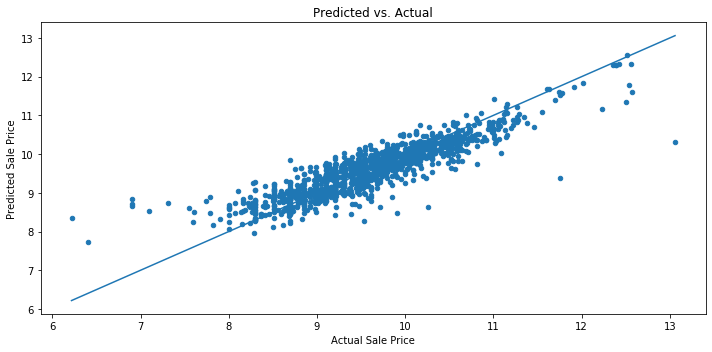

In [18]:
# Train model
ml = ml.fit(X_train1, y_train1)

# Predict test data set
y_pred = ml.predict(X_test1)

# Drawing regression graph
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [21]:
# Save the model to the pickle file
pickle.dump(ml, open("./Flask/models/model.plk","wb"))

In [22]:
# Set up a dataset using "brand", "model", "year", "miles", "price"
actual_car_info = train[["brand", "model","year","miles","price"]]

# Save the dataset to the pickle file
pickle.dump(actual_car_info, open("./Flask/models/actual_car_info.plk","wb"))

### Enter Used Car information

In [23]:
# Enter the information of the vehicle you want to know about the estimated price of used car
brand = str(input("brand: "))
model = str(input("model: "))
year = int(input("year: "))
miles = int(input("miles: "))

brand: kia
model: forte
year: 2015
miles: 80000


In [24]:
# Save the variable column used to train the model as a data frame
target = pd.DataFrame(columns = [X_train1.columns])

In [25]:
# Save the variable column to the pickle file
pickle.dump(X_train1.columns, open("./Flask/models/column.plk","wb"))

In [26]:
# Check the index location of the selected used car brand in the variable column data frame
brand_index = 0
for col in X_train1.columns:
    if col == 'brand'+"_"+brand:
        break;
    brand_index += 1
brand_index

25

In [27]:
# Check the index location of the selected used car model in the variable column data frame
model_index = 0
for col in X_train1.columns:
    if col == 'model'+"_"+model:
        break;
    model_index += 1
model_index

284

In [28]:
# Array of zeros
target_list = np.zeros_like(X_train1.loc[0])

In [29]:
# Save the target_list to pickle file
pickle.dump(target_list, open("./Flask/models/target_list.plk","wb"))

In [30]:
# Put the number 1 in the selected brand and model locations in the data frame
target_list[brand_index] = 1
target_list[model_index] = 1

# Put the year and miles in the data frame
target_list[0] = year
target_list[1] = miles

In [31]:
# Insert data into target data frame 
for i in range(1):
    target.loc[i] = target_list

In [32]:
# Nomalizing numerical features
numerical_features = ['year', 'miles']
normalize_target  = np.log1p(target[numerical_features])

In [33]:
target.drop(['year', 'miles'], axis=1, inplace=True)

/home/ubuntu/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [34]:
target_goal = normalize_target.join(target)

In [35]:
target_goal

,year,miles,brand_acura,brand_alfa,brand_aston,brand_audi,brand_bentley,brand_bmw,brand_buick,brand_cadillac,...,model_xt6,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z3,model_z4,model_zdx,model_zephyr
0,7.608871,11.289794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predict Used_Car Values

In [36]:
# Predicted logged price
price_log = ml.predict(target_goal)

In [37]:
price_log

array([8.841245], dtype=float32)

In [38]:
# Revert the logged price back to its original price
price = np.exp(price_log)
print("Price:", int(price))

Price: 6913


### Compare same model with different years

In [39]:
# Find the average of the same model for each year
same_model = actual_car_info[actual_car_info["model"]==model] 
year_price = same_model[["year", "price"]]
year_price_list = year_price.groupby("year").agg({'price':np.mean}).astype('int')
year_price_list = year_price_list.reset_index()
year_price_list

,year,price
0,2012,5597
1,2013,4950
2,2014,7524
3,2015,5993
4,2016,6996
5,2017,8413
6,2018,9999
7,2019,13697


In [40]:
# Convert year from number type to character type
year_price_list["year"] = year_price_list["year"].apply(lambda x: str(x) )

In [41]:
# Convert price from number type to character type
year_price_list["price"] = year_price_list["price"].apply(lambda x: str(x) )

In [42]:
list(year_price_list["price"])

['5597', '4950', '7524', '5993', '6996', '8413', '9999', '13697']